# **Experiment 3 - Convolutional Neural Network**

若有任何问题，可以QQ发消息给助教 442142110

**更新pip**

In [1]:
!python -m pip install --upgrade pip

distutils: /home/ma-user/anaconda3/envs/Pytorch-1.4.0/include/python3.6m/UNKNOWN
sysconfig: /home/ma-user/anaconda3/envs/Pytorch-1.4.0/include/python3.6m
user = False
home = None
root = None
prefix = None
Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
distutils: /home/ma-user/anaconda3/envs/Pytorch-1.4.0/include/python3.6m/UNKNOWN
sysconfig: /home/ma-user/anaconda3/envs/Pytorch-1.4.0/include/python3.6m
user = False
home = None
root = None
prefix = None


## **Install albumentations**
Albumentations is a fast and flexible image augmentation library. The library is widely used in industry, deep learning research, machine learning competitions, and open source projects. Albumentations is written in Python, and it is licensed under the MIT license.   
The source code is available at https://github.com/albumentations-team/albumentations.  
The **documentation** is available at https://albumentations.ai/docs/getting_started/image_augmentation/

In [8]:
# ! pip install --ignore-installed imageio
! pip install -U albumentations


distutils: /home/ma-user/anaconda3/envs/Pytorch-1.4.0/include/python3.6m/UNKNOWN
sysconfig: /home/ma-user/anaconda3/envs/Pytorch-1.4.0/include/python3.6m
user = False
home = None
root = None
prefix = None
Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
distutils: /home/ma-user/anaconda3/envs/Pytorch-1.4.0/include/python3.6m/UNKNOWN
sysconfig: /home/ma-user/anaconda3/envs/Pytorch-1.4.0/include/python3.6m
user = False
home = None
root = None
prefix = None


## **Install timm**
PyTorch Image Models (timm) is a collection of image models, layers, utilities, optimizers, schedulers, data-loaders / augmentations, and reference training / validation scripts that aim to pull together a wide variety of SOTA models with ability to reproduce ImageNet training results.

In [3]:
! pip install timm

distutils: /home/ma-user/anaconda3/envs/Pytorch-1.4.0/include/python3.6m/UNKNOWN
sysconfig: /home/ma-user/anaconda3/envs/Pytorch-1.4.0/include/python3.6m
user = False
home = None
root = None
prefix = None
Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
distutils: /home/ma-user/anaconda3/envs/Pytorch-1.4.0/include/python3.6m/UNKNOWN
sysconfig: /home/ma-user/anaconda3/envs/Pytorch-1.4.0/include/python3.6m
user = False
home = None
root = None
prefix = None


## **Preparatory Work**

**把数据从OBS复制到服务器中**

In [4]:
import moxing as mox 
# 需修改为自己的OBS目录
mox.file.copy('obs://lhy3/homework/food-11.zip', '/home/ma-user/work/food-11.zip') # 复制数据到当前路径

INFO:root:Using MoXing-v2.0.0.rc0-19e4d3ab
INFO:root:Using OBS-Python-SDK-3.20.9.1


**解压数据**

In [5]:
! unzip -o food-11.zip

Archive:  food-11.zip
  inflating: food-11/testing/0000.jpg  
  inflating: food-11/testing/0001.jpg  
  inflating: food-11/testing/0002.jpg  
  inflating: food-11/testing/0003.jpg  
  inflating: food-11/testing/0004.jpg  
  inflating: food-11/testing/0005.jpg  
  inflating: food-11/testing/0006.jpg  
  inflating: food-11/testing/0007.jpg  
  inflating: food-11/testing/0008.jpg  
  inflating: food-11/testing/0009.jpg  
  inflating: food-11/testing/0010.jpg  
  inflating: food-11/testing/0011.jpg  
  inflating: food-11/testing/0012.jpg  
  inflating: food-11/testing/0013.jpg  
  inflating: food-11/testing/0014.jpg  
  inflating: food-11/testing/0015.jpg  
  inflating: food-11/testing/0016.jpg  
  inflating: food-11/testing/0017.jpg  
  inflating: food-11/testing/0018.jpg  
  inflating: food-11/testing/0019.jpg  
  inflating: food-11/testing/0020.jpg  
  inflating: food-11/testing/0021.jpg  
  inflating: food-11/testing/0022.jpg  
  inflating: food-11/testing/0023.jpg  
  inflating: food-

In [6]:
! pip install dataclasses

distutils: /home/ma-user/anaconda3/envs/Pytorch-1.4.0/include/python3.6m/UNKNOWN
sysconfig: /home/ma-user/anaconda3/envs/Pytorch-1.4.0/include/python3.6m
user = False
home = None
root = None
prefix = None
Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
distutils: /home/ma-user/anaconda3/envs/Pytorch-1.4.0/include/python3.6m/UNKNOWN
sysconfig: /home/ma-user/anaconda3/envs/Pytorch-1.4.0/include/python3.6m
user = False
home = None
root = None
prefix = None


In [9]:
import os
import glob
import time
import timm
import numpy as np
import PIL.Image as Image
import pandas as pd
import albumentations as A  # 数据增强库
import matplotlib.pyplot as plt

from tqdm import tqdm  # 显示进度条
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

%matplotlib inline

ImportError: libpng15-c2ffaf3d.so.15.13.0: cannot open shared object file: No such file or directory

In [8]:
# 分别读入 training set、validation set、testing set 的文件路径


dataset_dir = 'food-11/'    # todo: 更换自己的文件路径
# dataset_dir = '/path/to/your/dataset/dir'
train_files = glob.glob(os.path.join(dataset_dir, 'training', '*'))  # 返回列表[training目录下所有文件的绝对路径]
val_files = glob.glob(os.path.join(dataset_dir, 'validation', '*'))

print(len(train_files), len(val_files))

9866 3430


# Dataset
在 Pytorch 中，我们可以利用 torch.utils.data 的 Dataset 及 DataLoader 來"包装" data，使后续的 training 及 testing 更為方便。

Dataset 需要 overload 两个函数：\_\_len\_\_ 及 \_\_getitem\_\_

\_\_len\_\_ 必须要回传 dataset 的大小，而 \_\_getitem\_\_ 则定义了当函数利用 [ ] 取值時，dataset 应该要怎么回传资料。

实际上我们并不会直接使用到这两个函数，但是使用 DataLoader 在 enumerate Dataset 时会使用到，沒有overload的话在函数运行阶段会出现 error。


In [9]:
#training 时做 data augmentation
train_transform = A.Compose([
    #A.HorizontalFlip(p=0.5), # 水平翻转，概率为0.5  
    #A.RandomBrightness(limit=2, p=0.5),#随机提升亮度
    #A.ElasticTransform(alpha=155, sigma=210, alpha_affine=157, p=0.5),
    A.Resize(224, 224, always_apply=True),  # 将不同尺寸的图像缩放到同一尺寸
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # 使用imagenet的均值和方差进行normalization
    ToTensorV2(), # 将numpy转换为Tensor， 并将图像（H,W,3）转换为（3,H,W）
])  # 其他方式的数据增强请参考官方文档

#testing 时候不需做 data augmentation
test_transform = A.Compose([
    A.Resize(224, 224, always_apply=True),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

class ImgDataset(Dataset):
    def __init__(self, files_list, transform=None, mode='train'):
        self.files_list = files_list
        self.transform = transform
        self.mode = mode
    
    def __getitem__(self, index):
        file = self.files_list[index]
        image = np.array(Image.open(file))
        
        if self.transform is not None:
            aug = self.transform(image=image)
            image = aug['image']
        
        if self.mode in ['train', 'val']: 
            label = int(os.path.basename(file).split('_')[0])
            return image, label

        else:
            return image
        
    def __len__(self):
        return len(self.files_list)

In [10]:
batch_size = 64
train_set = ImgDataset(train_files, train_transform, mode='train')
val_set = ImgDataset(val_files, test_transform, mode='val')
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)

# Model

In [11]:
mox.file.copy('obs://lhy3/homework/resnet34-43635321.pth', '/home/ma-user/.cache/torch/checkpoints/resnet34-43635321.pth') # 复制数据到当前路径

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = timm.create_model("resnet34", pretrained=True, num_classes=11, drop_rate=0.).to(device)

# Training

使用training set训练，并使用validation set寻找好的參數

In [ ]:
model = model.to(device)  # 如果有GPU则在GPU上运行, 否则为CPU
loss = nn.CrossEntropyLoss() # 因为是 classification task，所以 loss 使用 CrossEntropyLoss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # optimizer 使用 Adam
num_epoch = 10

train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
true_label = []
pred_label =[]

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    model.train() # 确保 model 是在 train model (开启 Dropout 等...)
    for image, label in tqdm(train_loader):
        optimizer.zero_grad() # 用 optimizer 将 model 参数的 gradient 置零
        
        image = image.to(device)  # 如果有GPU则在GPU上运行
        label = label.to(device)
        
        train_pred = model(image) # 利用 model 得到预测的概率分布 这边实际上就是去呼叫 model 的 forward 函数
        batch_loss = loss(train_pred, label) # 计算 loss （注意 prediction 跟 label 必须同时在 CPU 或是 GPU 上）
        batch_loss.backward() # 利用 back propagation 算出每個参数的 gradient
        optimizer.step() # 以 optimizer 用 gradient 更新参数值
        
        train_acc += torch.sum(torch.argmax(train_pred, dim=1) == label).item()
        train_loss += batch_loss.item()
       
    
    model.eval()
    with torch.no_grad():
        for image, label in tqdm(val_loader):
            image = image.to(device)
            label = label.to(device)
            if epoch==9:
                true_label.append(list(label.cpu().numpy()))
            
            val_pred = model(image)
            batch_loss = loss(val_pred, label)
            
            if epoch==9:
                pred_label.append(list(torch.argmax(val_pred,dim=1).cpu().numpy()))

            val_acc += torch.sum(torch.argmax(val_pred, dim=1) == label).item()
            val_loss += batch_loss.item()

    
    train_acc_list.append(train_acc / train_set.__len__())
    train_loss_list.append(train_loss / train_set.__len__())
    val_acc_list.append(val_acc / val_set.__len__())
    val_loss_list.append(val_loss / val_set.__len__())
    
        #將結果 print 出來
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f | Val Acc: %3.6f loss: %3.6f' % \
        (epoch + 1, num_epoch, time.time()-epoch_start_time, \
         train_acc/train_set.__len__(), train_loss/train_set.__len__(), val_acc/val_set.__len__(), val_loss/val_set.__len__()))

  0%|          | 0/154 [00:00<?, ?it/s]

[001/010] 1316.20 sec(s) Train Acc: 0.795459 Loss: 0.010444 | Val Acc: 0.873761 loss: 0.006289


In [ ]:
true_label=sum(true_label,[])
pred_label=sum(pred_label,[])

In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_label, pred_label)
plt.figure(figsize=(10,10))
plt.imshow(cm,cmap=plt.cm.Oranges)
indices = range(len(cm))
plt.xticks(indices,[0,1,2,3,4,5,6,7,8,9,10])
plt.yticks(indices,[0,1,2,3,4,5,6,7,8,9,10])
plt.colorbar()
plt.xlabel('Real')
plt.ylabel('Predict')
plt.title('validation Confusion Matrix')
for first_index in range(len(cm)):
    for second_index in range(len(cm[first_index])):
        plt.text(first_index,second_index,cm[first_index][second_index])
plt.show()

AttributeError: 'ImgDataset' object has no attribute 'targets'

查看训练过程accuracy和loss曲线

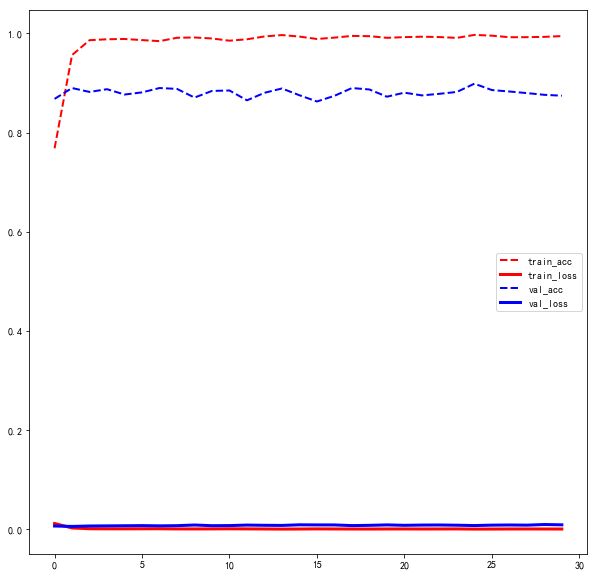

In [14]:
plt.figure(figsize=(10, 10))
plt.plot(range(num_epoch), train_acc_list, color='red', linewidth=2.0, linestyle='--', label='train_acc')
plt.plot(range(num_epoch), train_loss_list, color='red', linewidth=3.0, linestyle='-', label='train_loss')
plt.plot(range(num_epoch), val_acc_list, color='blue', linewidth=2.0, linestyle='--', label='val_acc')
plt.plot(range(num_epoch), val_loss_list, color='blue', linewidth=3.0, linestyle='-', label='val_loss')

plt.legend()
plt.show()

得到好的参数后，我们使用training set和validation set共同训练（数据量增加，模型效果一般有提升）

In [19]:
train_val_files = train_files + val_files
train_val_set = ImgDataset(train_val_files, train_transform, mode='train')
train_val_loader = DataLoader(train_val_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

In [20]:
model_best = timm.create_model("resnet34", pretrained=True, num_classes=11, drop_rate=0.).to(device)

loss = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model_best.parameters(), lr=0.001) 
num_epoch = 30

for epoch in range(num_epoch):
    epoch_start_time = time.time()
    train_acc = 0.0
    train_loss = 0.0

    model_best.train()
    for image, label in tqdm(train_val_loader):
        optimizer.zero_grad()
        
        image = image.to(device)  # 如果有GPU则在GPU上运行
        label = label.to(device)
        
        train_pred = model_best(image)
        batch_loss = loss(train_pred,label)
        batch_loss.backward()
        optimizer.step()
        
        train_acc += torch.sum(torch.argmax(train_pred, dim=1) == label).item()
        train_loss += batch_loss.item()

        #將結果 print 出來
    print('[%03d/%03d] %2.2f sec(s) Train Acc: %3.6f Loss: %3.6f' % \
      (epoch + 1, num_epoch, time.time()-epoch_start_time, \
      train_acc/train_val_set.__len__(), train_loss/train_val_set.__len__()))


  0%|          | 0/207 [00:00<?, ?it/s]

[001/030] 41.23 sec(s) Train Acc: 0.691336 Loss: 0.014926


  0%|          | 0/207 [00:00<?, ?it/s]

[002/030] 41.07 sec(s) Train Acc: 0.812575 Loss: 0.008796


  0%|          | 0/207 [00:00<?, ?it/s]

[003/030] 41.55 sec(s) Train Acc: 0.869284 Loss: 0.006156


  0%|          | 0/207 [00:00<?, ?it/s]

[004/030] 41.24 sec(s) Train Acc: 0.901775 Loss: 0.004487


  0%|          | 0/207 [00:00<?, ?it/s]

[005/030] 41.62 sec(s) Train Acc: 0.923060 Loss: 0.003496


  0%|          | 0/207 [00:00<?, ?it/s]

[006/030] 41.50 sec(s) Train Acc: 0.942614 Loss: 0.002516


  0%|          | 0/207 [00:00<?, ?it/s]

[007/030] 41.29 sec(s) Train Acc: 0.956679 Loss: 0.001863


  0%|          | 0/207 [00:00<?, ?it/s]

[008/030] 41.13 sec(s) Train Acc: 0.959085 Loss: 0.001742


  0%|          | 0/207 [00:00<?, ?it/s]

[009/030] 41.13 sec(s) Train Acc: 0.970292 Loss: 0.001282


  0%|          | 0/207 [00:00<?, ?it/s]

[010/030] 41.10 sec(s) Train Acc: 0.964801 Loss: 0.001512


  0%|          | 0/207 [00:00<?, ?it/s]

[011/030] 41.07 sec(s) Train Acc: 0.974203 Loss: 0.001085


  0%|          | 0/207 [00:00<?, ?it/s]

[012/030] 41.38 sec(s) Train Acc: 0.977211 Loss: 0.000919


  0%|          | 0/207 [00:00<?, ?it/s]

[013/030] 41.28 sec(s) Train Acc: 0.972172 Loss: 0.001069


  0%|          | 0/207 [00:00<?, ?it/s]

[014/030] 41.38 sec(s) Train Acc: 0.980220 Loss: 0.000814


  0%|          | 0/207 [00:00<?, ?it/s]

[015/030] 41.39 sec(s) Train Acc: 0.974880 Loss: 0.000944


  0%|          | 0/207 [00:00<?, ?it/s]

[016/030] 41.20 sec(s) Train Acc: 0.979392 Loss: 0.000831


  0%|          | 0/207 [00:00<?, ?it/s]

[017/030] 41.43 sec(s) Train Acc: 0.984206 Loss: 0.000594


  0%|          | 0/207 [00:00<?, ?it/s]

[018/030] 41.24 sec(s) Train Acc: 0.980897 Loss: 0.000753


  0%|          | 0/207 [00:00<?, ?it/s]

[019/030] 41.28 sec(s) Train Acc: 0.984883 Loss: 0.000610


  0%|          | 0/207 [00:00<?, ?it/s]

[020/030] 41.22 sec(s) Train Acc: 0.982175 Loss: 0.000685


  0%|          | 0/207 [00:00<?, ?it/s]

[021/030] 41.10 sec(s) Train Acc: 0.986688 Loss: 0.000459


  0%|          | 0/207 [00:00<?, ?it/s]

[022/030] 41.20 sec(s) Train Acc: 0.983378 Loss: 0.000655


  0%|          | 0/207 [00:00<?, ?it/s]

[023/030] 41.32 sec(s) Train Acc: 0.983905 Loss: 0.000565


  0%|          | 0/207 [00:00<?, ?it/s]

[024/030] 41.77 sec(s) Train Acc: 0.984131 Loss: 0.000614


  0%|          | 0/207 [00:00<?, ?it/s]

[025/030] 41.18 sec(s) Train Acc: 0.984131 Loss: 0.000557


  0%|          | 0/207 [00:00<?, ?it/s]

[026/030] 41.31 sec(s) Train Acc: 0.987064 Loss: 0.000444


  0%|          | 0/207 [00:00<?, ?it/s]

[027/030] 41.29 sec(s) Train Acc: 0.986537 Loss: 0.000456


  0%|          | 0/207 [00:00<?, ?it/s]

[028/030] 41.22 sec(s) Train Acc: 0.985334 Loss: 0.000546


  0%|          | 0/207 [00:00<?, ?it/s]

[029/030] 41.36 sec(s) Train Acc: 0.991200 Loss: 0.000253


100%|██████████| 207/207 [00:41<00:00,  5.03it/s]

[030/030] 41.15 sec(s) Train Acc: 0.981949 Loss: 0.000659


保存模型

In [22]:
state_dict = model_best.state_dict()
torch.save(state_dict, 'model_best.pth')

In [ ]:
mox.file.copy( '/home/ma-user/work/model_best.pth','obs://lhy3/homework/model_best.pth') # 把模型保存至obs中，在home page即可下载